In this notebook, let us try and explore the data given for Zillow prize competition. Before we dive deep into the data, let us know a little more about the competition.

**Zillow:**

Zillow is an online real estate database company founded in 2006 - Wikipedia

**Zestimate:**

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today),

**Objective:**

Building a model to improve the Zestimate residual error.

The competition is in two stages. This public competition will go on till Jan 2018 and has $50,000 in prize. Please make sure to read about the [Prize details][1] and [Competition overview][2] since it is quite different in this one.

Let us first import the necessary modules.


  [1]: https://www.kaggle.com/c/zillow-prize-1#prizes
  [2]: https://www.kaggle.com/c/zillow-prize-1#Competition%20Overview

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

Let us list the files present in the input folder.

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

properties_2016.csv
properties_2017.csv
sample_submission.csv
train_2016_v2.csv
train_2017.csv
zillow_data_dictionary.xlsx



First let us start with the train file exploration.

In [4]:
train_df = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In [5]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


**Logerror:**

Target variable for this competition is "logerror" field. So let us do some analysis on this field first. 

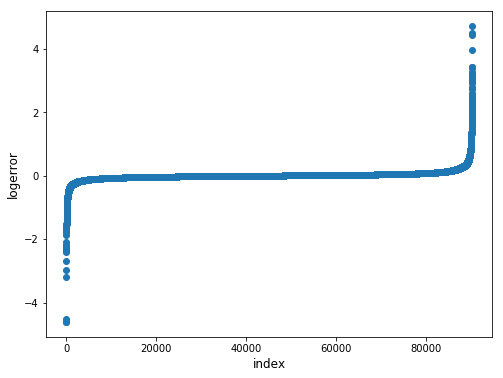

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

This looks nice with some outliers at both the ends.! 

Let us remove the outliers and then do a histogram plot on the same.

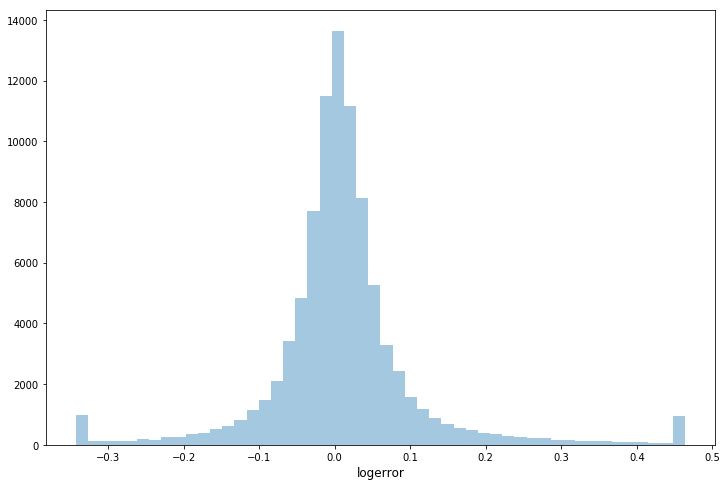

In [9]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'].loc[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].loc[train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Wow. nice normal distribution on the log error.

**Transaction Date:**

Now let us explore the date field. Let us first check the number of transactions in each month. 

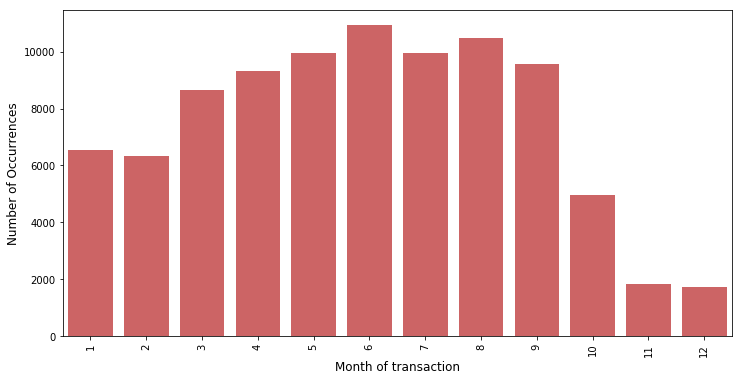

In [10]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

As we could see from the data page as well
*The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.*

So we have shorter bars in the last three months. 

**Parcel Id:**

In [11]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

So most of the parcel ids are appearing only once in the dataset.

**Properties 2016:**

Now let us explore the properties_2016 file. 

In [ ]:
prop_df = pd.read_csv("../input/properties_2016.csv")
prop_df.shape

In [ ]:
prop_df.head()

There are so many NaN values in the dataset. So let us first do some exploration on that one. 

In [ ]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Let us explore the latitude and longitude variable to begin with.

In [ ]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

From the data page, *we are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.*

We have about 90,811 rows in train but we have about 2,985,217 rows in properties file. So let us merge the two files and then carry out our analysis. 

In [ ]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

Now let us check the dtypes of different types of variable.

In [ ]:
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

Almost all are float variables with few object (categorical) variables. Let us get the count. 

In [ ]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

Now let us check the number of Nulls in this new merged dataset.

In [ ]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.ix[missing_df['missing_ratio']>0.999]

Four columns have missing values 99.9% of the times.!

**Univariate Analysis:**

Since there are so many variables, let us first take the 'float' variables alone and then get the correlation with the target variable to see how they are related.

In [ ]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values, inplace=True)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

The correlation of the target variable with the given set of variables are low overall. 

There are few variables at the top of this graph without any correlation values. I guess they have only one unique value and hence no correlation value. Let us confirm the same.

In [ ]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

Let us take the variables with high correlation values and then do some analysis on them. 

In [ ]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

In [ ]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

The important variables themselves are very highly correlated.! Let us now look at each of them.

**Finished SquareFeet 12:**

Let us seee how the finished square feet 12 varies with the log error.

In [ ]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Seems the range of logerror narrows down with increase in finished square feet 12 variable. Probably larger houses are easy to predict?

**Calculated finished square feet:**

In [ ]:
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

Here as well the distribution is very similar to the previous one. No wonder the correlation between the two variables are also high.

**Bathroom Count:**

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

There is an interesting 2.279 value in the bathroom count.

Edit: As MihwaHan pointed in the comments, this is the mean value :)

Now let us check how the log error changes based on this.

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

**Bedroom count:**

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

3.03 is the mean value with which we replaced the Null values.

In [ ]:
train_df['bedroomcnt'].ix[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

In [ ]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

**YearBuilt:**

Let us explore how the error varies with the yearbuilt variable.

In [ ]:
from ggplot import *
ggplot(aes(x='yearbuilt', y='logerror'), data=train_df) + \
    geom_point(color='steelblue', size=1) + \
    stat_smooth()

There is a minor incremental trend seen with respect to built year.

Now let us see how the logerror varies with respect to latitude and longitude.

In [ ]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

There are no visible pockets as such with respect to latitude or longitude atleast with the naked eye.

Let us take the variables with highest positive correlation and highest negative correlation to see if we can see some visible patterns.

In [ ]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_point(alpha=0.7) + \
    scale_color_gradient(low = 'pink', high = 'blue')

There are no visible patterns here as well. So this is going to be a hard competition to predict I guess.

Just for fun, we will let the machine form some arbitrary pattern for us :D

In [ ]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_now_its_art()

Hurray.! Finally we got some nice pattern in the data :P

We had an understanding of important variables from the univariate analysis. But this is on a stand alone basis and also we have linearity assumption. Now let us build a non-linear model to get the important variables by building Extra Trees model.

In [ ]:
train_y = train_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Seems "tax amount" is the most importanct variable followed by "structure tax value dollar count" and "land tax value dollor count"



In [ ]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(train_df, train_y, feature_names=train_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Using xgboost, the important variables are 'structured tax value dollar count' followed by 'latitude' and 'calculated finished square feet' 

**More to come. Stay tuned.!**

**Please upvote if you find it useful :)**